In [45]:
import numpy as np
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from Mesh.Charges_utils import get_charges_list
from Model.Solutions_utils import Solution_utils

from Mesh.Mesh import Domain_Mesh
from Post.Postcode import Postprocessing as Post
from Simulation import get_simulation_name

simulation_name,results_path,main_path,logger = get_simulation_name(os.path.join(os.path.dirname(os.getcwd()), 'dataset.py'))

file_path = os.getcwd()

In [46]:

molecule = 'methanol'


Rs = {'born_ion': 1,
      'methanol': 2.54233,
      'arg': 5.9695745,
      'sphere': 1.2,
      'sphere_+1-1': 1.2,
      'sphere_+1+1': 1.2,
      'sphere_+2-1': 1.2,
      'sphere_+1_D': 1.2,
      'sphere_0.2': 1.2}

Model = Solution_utils()

Model.pqr_path = os.path.join(os.getcwd(),molecule,f'{molecule}.pqr')
q_list = get_charges_list(Model.pqr_path)

Model.domain_properties = {
        'molecule': molecule,
        'epsilon_1':  1,
        'epsilon_2': 80,
        'kappa': 0.125,
        'T' : 300 
        }

Model.epsilon_1 = Model.domain_properties['epsilon_1']
Model.epsilon_2 = Model.domain_properties['epsilon_2']
Model.kappa = Model.domain_properties['kappa']
Model.pi = np.pi
Model.q_list = q_list

n = len(Model.q_list)
Model.qs = np.zeros(n)
Model.x_qs = np.zeros((n,3))
for i,q in enumerate(Model.q_list):
    Model.qs[i] = q.q
    Model.x_qs[i,:] = q.x_q
Model.total_charge = np.sum(Model.qs)

dR = 0.1
R_mol = Rs[molecule]
Rmin = dR + R_mol
Rmax = Rmin + 3


In [47]:
Model.mesh_density = 5
Model.mesh_generator = 'msms'
phi_q = Model.phi_known('pbj','react',Model.x_qs,'molecule')
Model.solvation_energy_phi_qs(phi_q)

/home/martinachondo/PINN/code/pbj/mesh/ExternalSoftware/MSMS/msms -if /home/martinachondo/PINN/code/Molecules/mesh_temp/methanol.xyzr -of /home/martinachondo/PINN/code/Molecules/mesh_temp/methanol -p 1.4 -d 5 -no_header
MSMS 2.6.1 started on tulio
Copyright M.F. Sanner (1994)
Compilation flags -O2 -DVERBOSE -DTIMING
INPUT  /home/martinachondo/PINN/code/Molecules/mesh_temp/methanol.xyzr 3 spheres 0 collision only, radii  0.200 to  1.888
PARAM  Probe_radius  1.400 density  5.000 hdensity  3.000
REDUCED SURFACE ...
    RS component  #faces  #edges #free_edges  #vertices   genus
         0           0        0          1          2      0.5
    Time Reduced Surface real: 0.01 user: 0.00 sys: 0.00
ANALYTICAL SOLVENT EXCLUDED SURFACE...
    Component   0
        Time Surface real: 0.00 user: 0.00 sys: 0.00
    SES comp.  #fac.  #edg. #s_edg. #vert. #s_vert. R_h C_h genus
         0        3      3      0       2        0   0   0    0
ANALYTICAL SURFACE AREA :
    Comp. probe_radius,   reent,

    Couldn't find first face trying -all option


-12.430738432192282

In [5]:
q_list

[Charges(q=0.27, x_q=array([0.019 , 0.    , 0.6556]), r_q=1.8875, atom_name='CH3', res_name='MEOH', res_num='1', ion_r_explode=3.5),
 Charges(q=-0.7, x_q=array([-0.1197,  0.    , -0.7372]), r_q=1.535, atom_name='O', res_name='MEOH', res_num='1', ion_r_explode=3.5),
 Charges(q=0.43, x_q=array([ 0.737,  0.   , -1.139]), r_q=0.2, atom_name='H', res_name='MEOH', res_num='1', ion_r_explode=3.5)]

### Calculate Solvation energy

In [6]:
phi_q = Model.Harmonic_spheres(Model.x_qs,'molecule',R_mol)
print(Model.solvation_energy_phi_qs(phi_q))
print(phi_q)
Model.solvation_energy_phi_qs(phi_q)

-3.3912698008786037
[-0.00072111  0.00097837 -0.00173453]


-3.3912698008786037

### Plot phi

In [ ]:
domain_properties = {
    'molecule': molecule,
    }
    
mesh_properties = {
        'vol_mx_interior': 0.05,
        'vol_max_exterior': 0.5,
        'density_mol': 2,
        'density_border': 3,
        'dx_experimental': 0.8,
        'N_pq': 100,
        'G_sigma': 0.04,
        'mesh_generator': 'msms',
        'dR_exterior': 5
        }



Mol_mesh = Domain_Mesh(domain_properties['molecule'], 
                mesh_properties=mesh_properties, 
                save_points=True,
                path=main_path,
                simulation=simulation_name
                )

Post.mesh = Mol_mesh
Model.mesh = Mol_mesh
Model.DTYPE = 'float64'

In [9]:
N=200
x0=np.array([0,0,0])
theta=0
phi=np.pi/2

r = np.linspace(-Mol_mesh.R_exterior,Mol_mesh.R_exterior,N)
x = x0[0] + r * np.sin(phi) * np.cos(theta) + Mol_mesh.centroid[0]
y = x0[1] + r * np.sin(phi) * np.sin(theta) + Mol_mesh.centroid[1]
z = x0[2] + r * np.cos(phi) + Mol_mesh.centroid[2]
points = np.stack((x.ravel(), y.ravel(), z.ravel()), axis=1)
X_in,X_out,_ = Post.get_interior_exterior(Post,points)

X = [X_in,X_out,x0]

In [18]:
field = 'react'

u_in_Yuk = Model.phi_known('G_Yukawa',field,X_in,'molecule',Mol_mesh.R_max_dist)
u_out_Yuk = Model.phi_known('G_Yukawa',field,X_out,'solvent',Mol_mesh.R_max_dist)

u_in_Born = Model.phi_known('analytic_Born_Ion',field,X_in,'molecule',Mol_mesh.R_max_dist)
u_out_Born = Model.phi_known('analytic_Born_Ion',field,X_out,'solvent',Mol_mesh.R_max_dist)

u_in_Har = Model.phi_known('Harmonic_spheres',field,X_in,'molecule',Mol_mesh.R_max_dist)
u_out_Har = Model.phi_known('Harmonic_spheres',field,X_out,'solvent',Mol_mesh.R_max_dist)

u_in_pbj = Model.phi_known('pbj',field,X_in,'molecule',Mol_mesh.R_max_dist)
u_out_pbj = Model.phi_known('pbj',field,X_out,'solvent',Mol_mesh.R_max_dist)


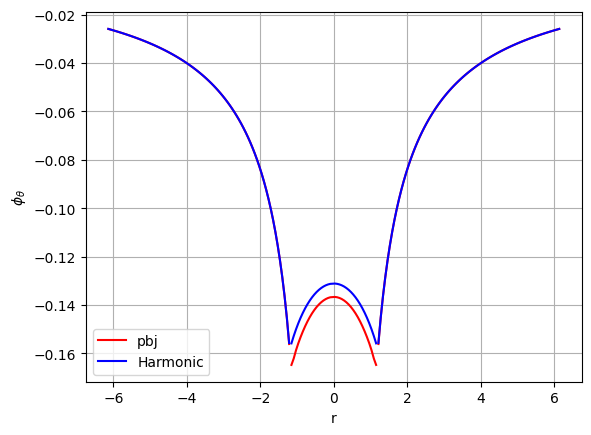

In [19]:
fig,ax = Post.plot_phis_line([(u_in_pbj,u_out_pbj),(u_in_Har,u_out_Har)],X,['pbj','Harmonic'])
#ax.set_ylim([np.min(u_out_Har)-0.01,np.max(u_in_Har)+0.01])

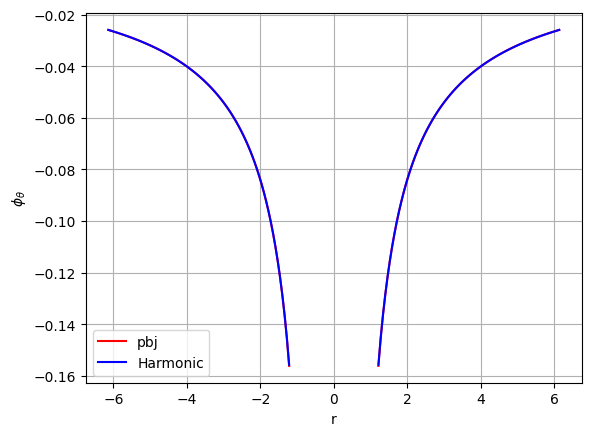

In [20]:
fig,ax = Post.plot_phis_line([(u_in_pbj,u_out_pbj),(u_in_Har,u_out_Har)],X,['pbj','Harmonic'],domain='solvent')
# ax.set_ylim([-0.001,0.003])

### 3D PBJ

In [37]:
Post.plot_interface_3D_known(Post,Post.PDE.pbj_phi,Post.PDE.vertices,Post.PDE.elements);

In [36]:
phi = Model.phi_known('G_Yukawa','react',Post.mesh.mol_verts,'molecule')
Post.plot_interface_3D_known(Post,phi,Post.mesh.mol_verts,Post.mesh.mol_faces);